In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet

Оптимизация розничных цен

Ссылка: https://www.kaggle.com/datasets/suddharshan/retail-price-optimization

Данные содержат информацию о спросе и соответствующей средней цене за единицу товара на уровне месяц_год.

Целевая переменная - unit_price (средняя цена за единицу товара).

Показатели, влияющие на среднюю цену за единицу товара: цена товара за продыдущий месяц (lag_price), кол-во проданных товаров (qty) , средняя стоимость перевозки (freight_price), вес (product_weight_g), средний рейтинг продукта (product_score); цена, рейтинг,цена перевозки конкурентов (comp_1, ps1, fp1 и др) и другие.



In [2]:
data = pd.read_csv('retail_price.csv')
data

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.950000,39,161,2,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.900000
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.950000,39,161,2,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.950000
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.950000,39,161,2,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.950000
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.950000,39,161,2,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.950000
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.950000,39,161,2,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,bed5,bed_bath_table,01-05-2017,1,215.00,8.760000,215.000000,56,162,5,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,214.950000
672,bed5,bed_bath_table,01-06-2017,10,2090.00,21.322000,209.000000,56,162,5,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,215.000000
673,bed5,bed_bath_table,01-07-2017,59,12095.00,22.195932,205.000000,56,162,5,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,209.000000
674,bed5,bed_bath_table,01-08-2017,52,10375.00,19.412885,199.509804,56,162,5,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,205.000000


Описание датасета

In [3]:
data.shape

(676, 30)

In [4]:
data.describe(include='all')

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
count,676,676,676,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,...,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
unique,52,9,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,health5,garden_tools,01-03-2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,20,160,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,14.495562,1422.708728,20.682270,106.496800,48.720414,767.399408,1.994083,...,79.452054,4.159467,18.597610,92.930079,4.123521,18.620644,84.182642,4.002071,17.965007,107.399684
std,NaN,NaN,NaN,15.443421,1700.123100,10.081817,76.182972,9.420715,655.205015,1.420473,...,47.933358,0.121652,9.406537,49.481269,0.207189,6.424174,47.745789,0.233292,5.533256,76.974657
min,NaN,NaN,NaN,1.000000,19.900000,0.000000,19.900000,29.000000,100.000000,1.000000,...,19.900000,3.700000,0.095439,19.900000,3.300000,4.410000,19.900000,3.500000,7.670000,19.850000
25%,NaN,NaN,NaN,4.000000,333.700000,14.761912,53.900000,40.000000,339.000000,1.000000,...,49.910000,4.100000,13.826429,53.900000,4.100000,14.485000,53.785714,3.900000,15.042727,55.668750
50%,NaN,NaN,NaN,10.000000,807.890000,17.518472,89.900000,51.000000,501.000000,1.500000,...,69.900000,4.200000,16.618984,89.990000,4.200000,16.811765,59.900000,4.000000,16.517110,89.900000
75%,NaN,NaN,NaN,18.000000,1887.322500,22.713558,129.990000,57.000000,903.000000,2.000000,...,104.256549,4.200000,19.732500,117.888889,4.200000,21.665238,99.990000,4.100000,19.447778,129.990000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

Заменим категориальные признаки на числовые

In [6]:
label_encoder = LabelEncoder()
data['product_category_name'] = label_encoder.fit_transform(data['product_category_name'])
data['product_id'] = label_encoder.fit_transform(data['product_id'])
data

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,0,0,01-05-2017,1,45.95,15.100000,45.950000,39,161,2,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.900000
1,0,0,01-06-2017,3,137.85,12.933333,45.950000,39,161,2,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.950000
2,0,0,01-07-2017,6,275.70,14.840000,45.950000,39,161,2,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.950000
3,0,0,01-08-2017,4,183.80,14.287500,45.950000,39,161,2,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.950000
4,0,0,01-09-2017,2,91.90,15.100000,45.950000,39,161,2,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,4,0,01-05-2017,1,215.00,8.760000,215.000000,56,162,5,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,214.950000
672,4,0,01-06-2017,10,2090.00,21.322000,209.000000,56,162,5,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,215.000000
673,4,0,01-07-2017,59,12095.00,22.195932,205.000000,56,162,5,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,209.000000
674,4,0,01-08-2017,52,10375.00,19.412885,199.509804,56,162,5,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,205.000000


Удалим month_year, поскольку в датасете есть отдельные столбцы month и year

In [7]:
data = data.drop('month_year', axis=1)

In [8]:
data.columns

Index(['product_id', 'product_category_name', 'qty', 'total_price',
       'freight_price', 'unit_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price'],
      dtype='object')

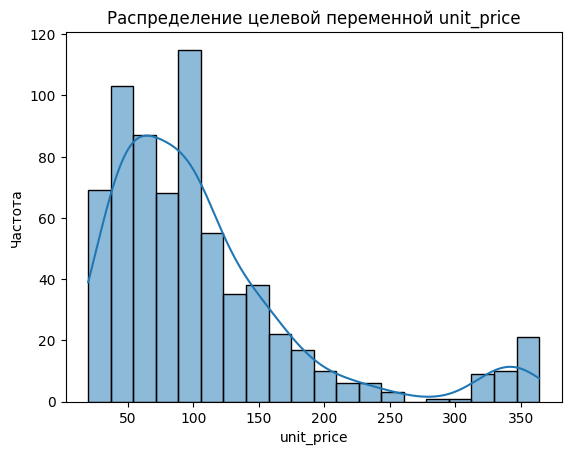

In [9]:
sns.histplot(data['unit_price'], kde=True)
plt.title('Распределение целевой переменной unit_price')
plt.xlabel('unit_price')
plt.ylabel('Частота')
plt.show()

Диаграммы рассеяния (зависимость целевой переменной от признаков)

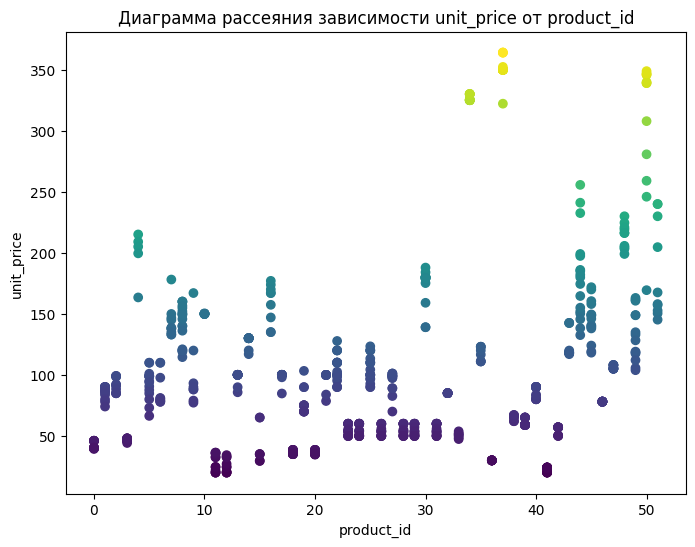

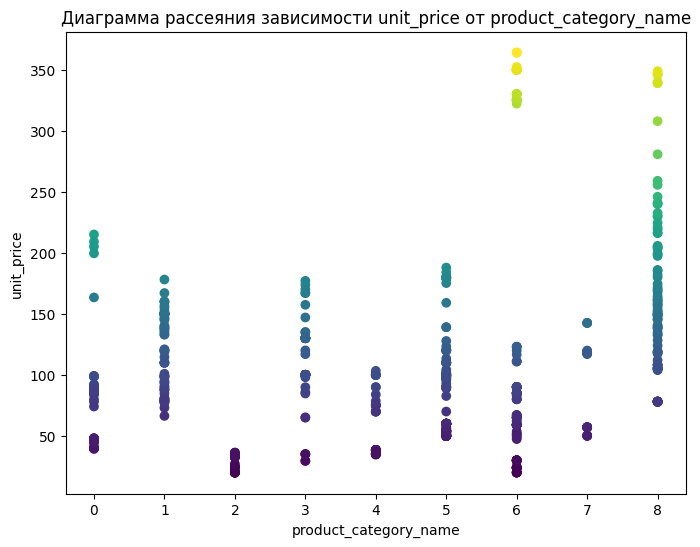

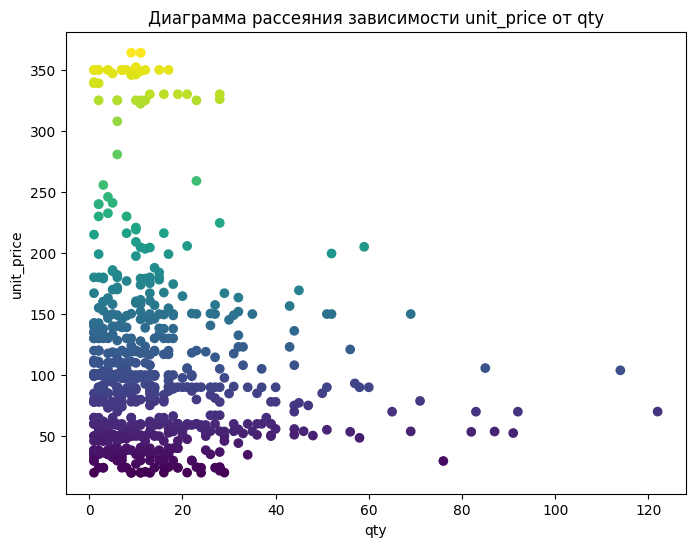

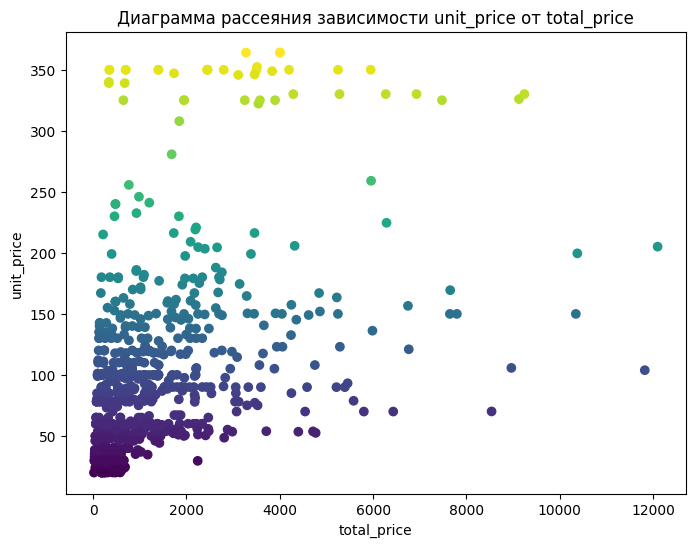

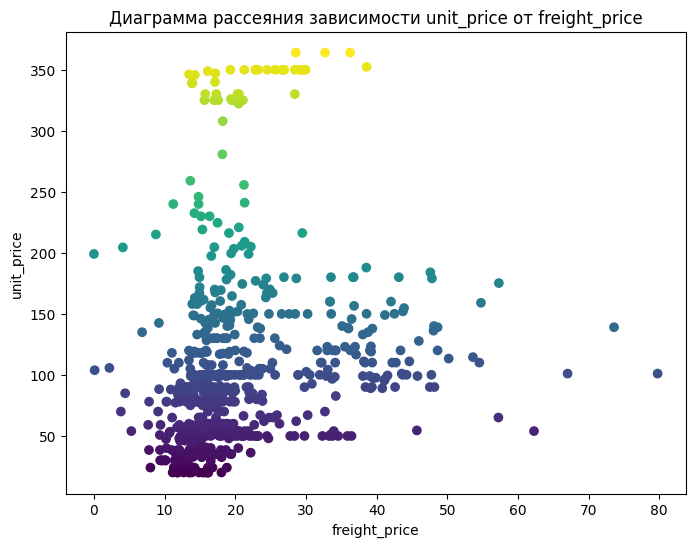

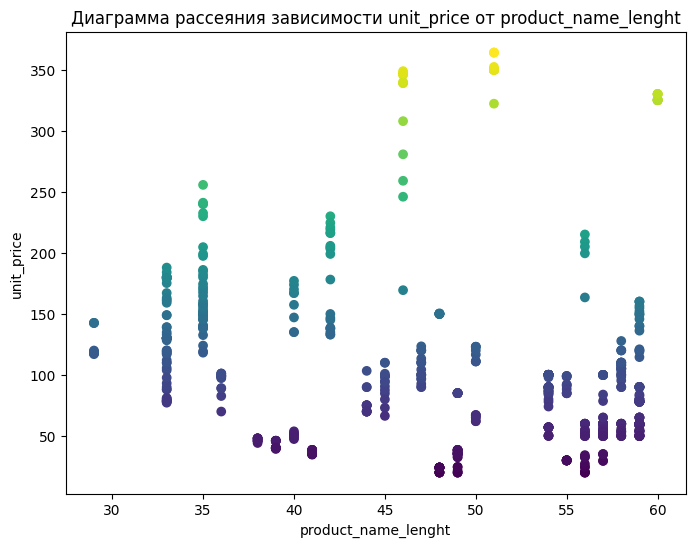

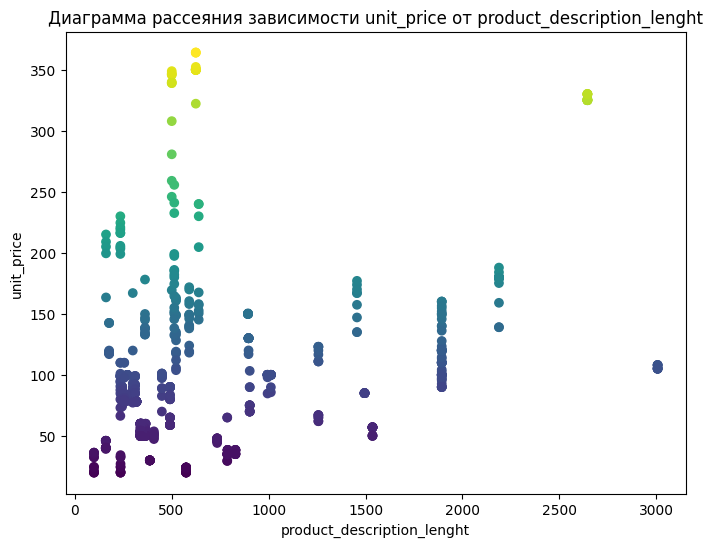

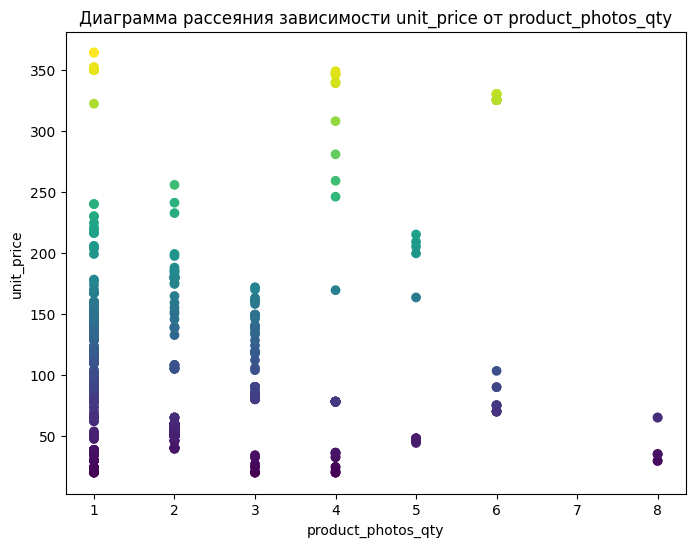

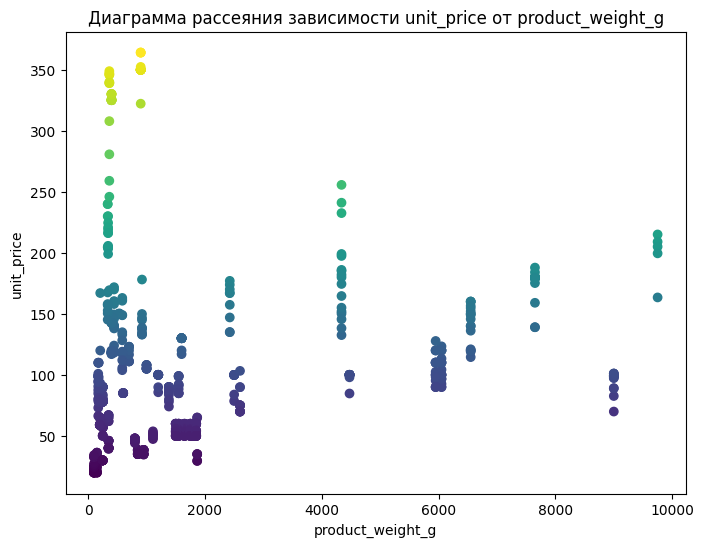

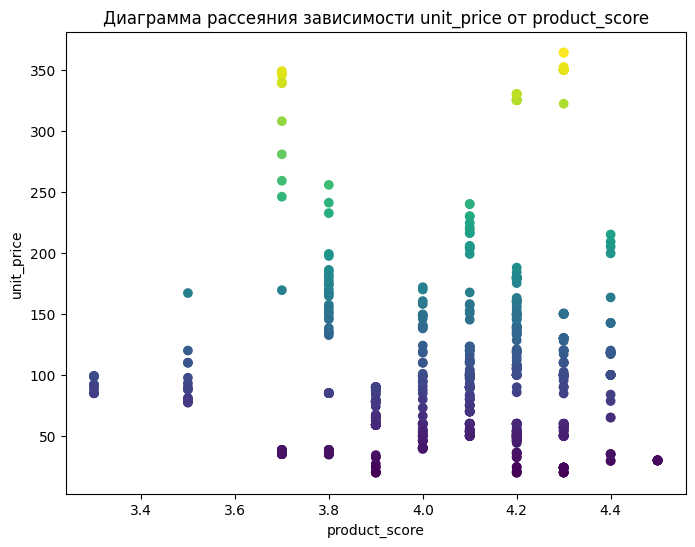

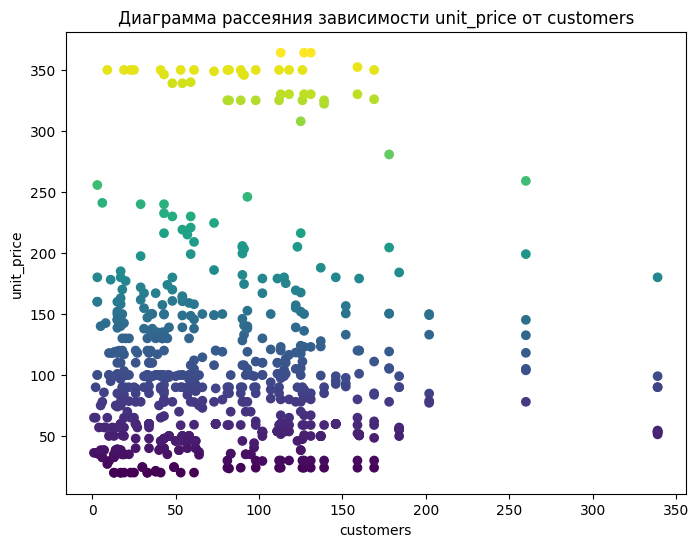

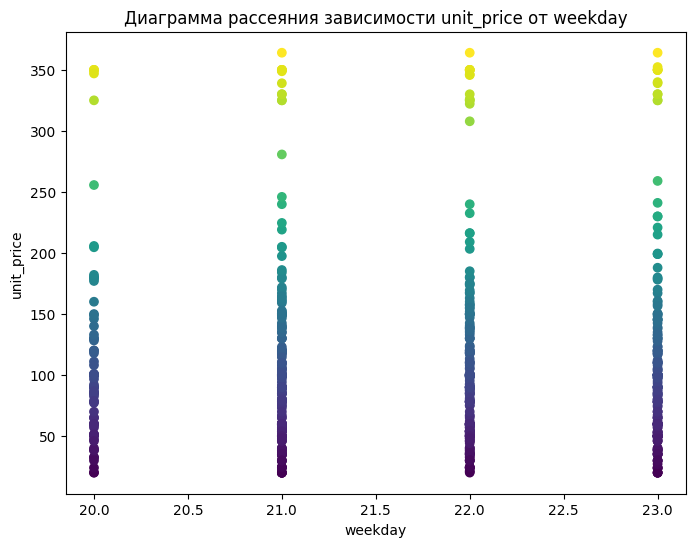

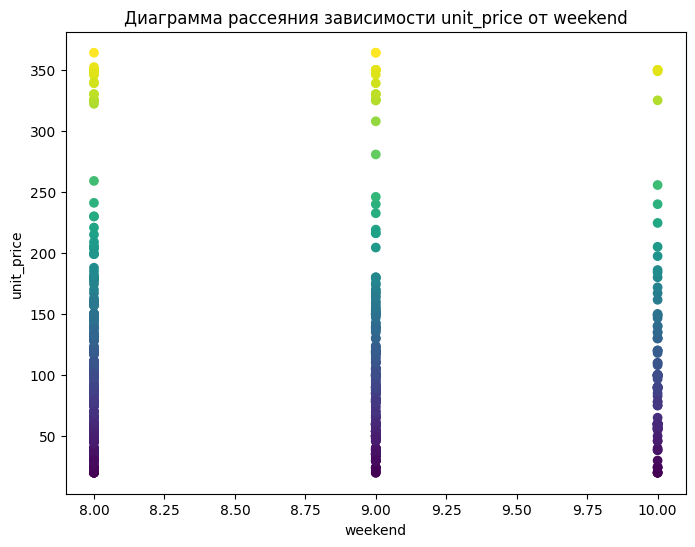

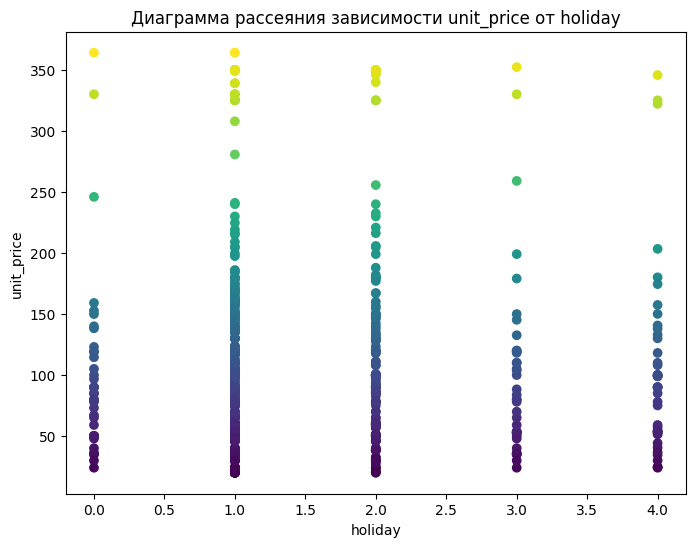

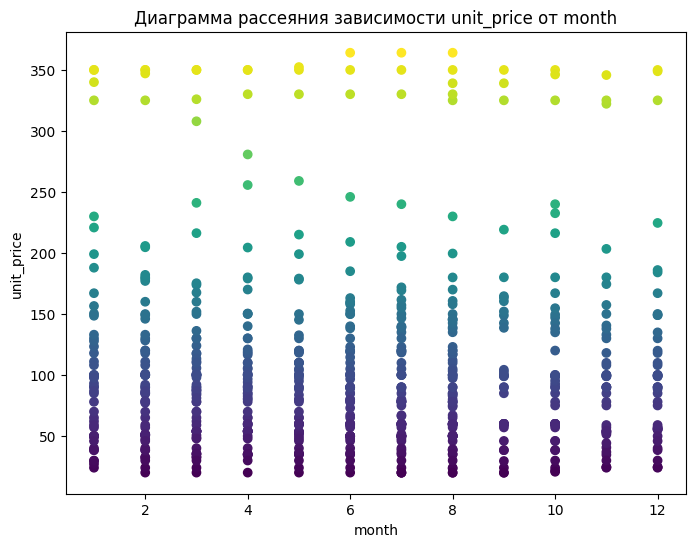

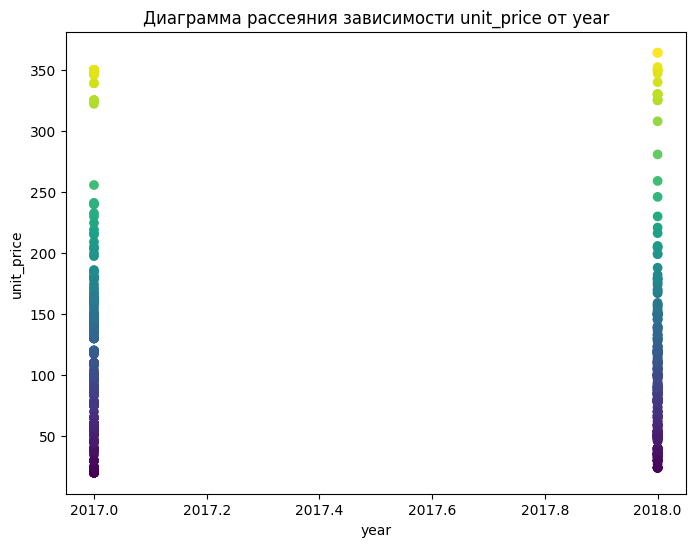

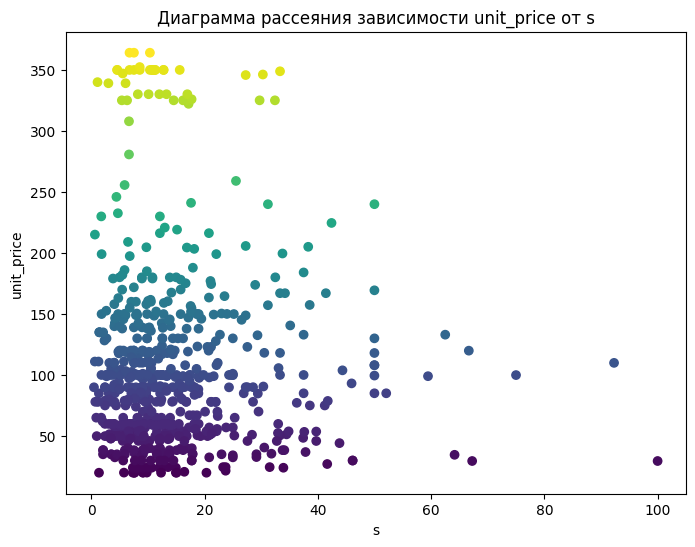

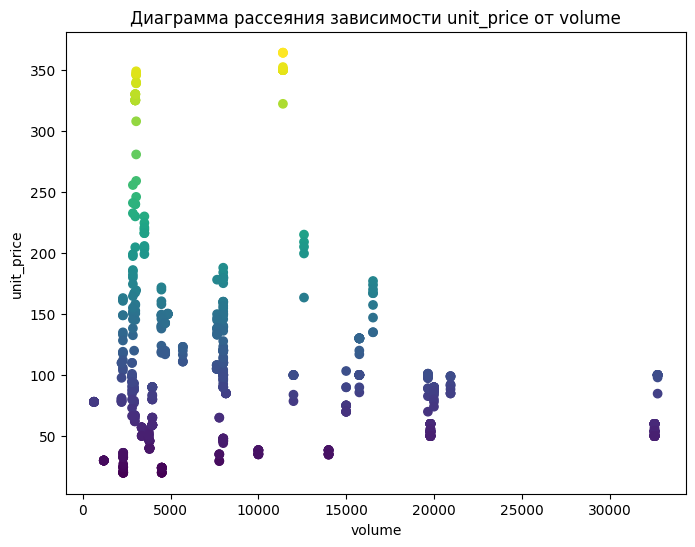

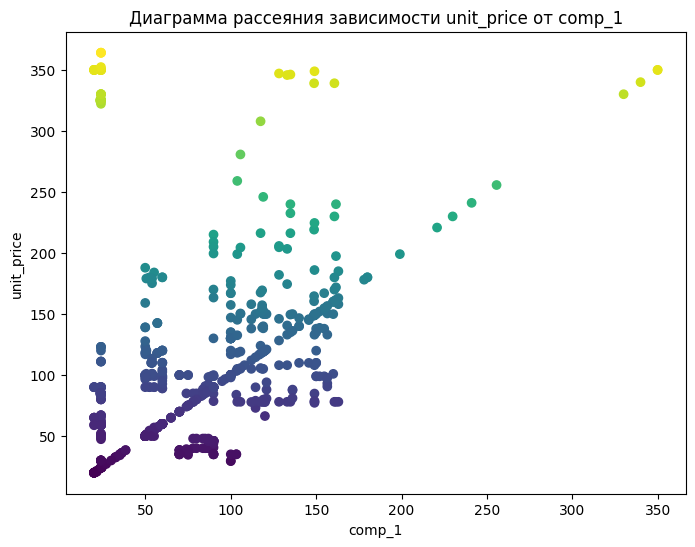

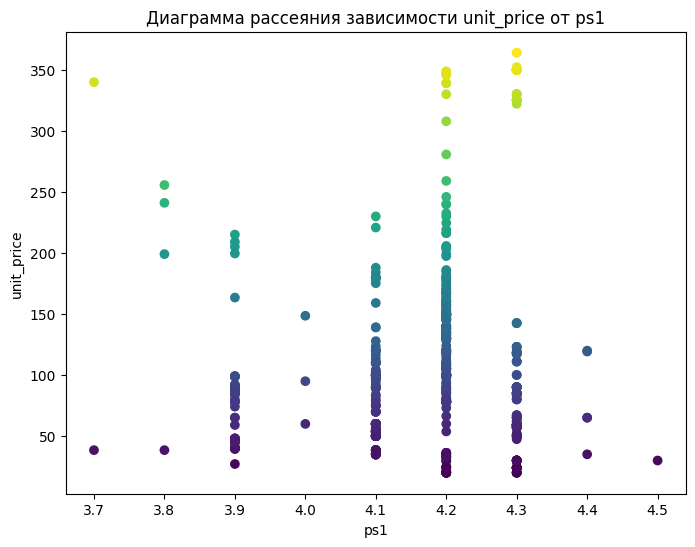

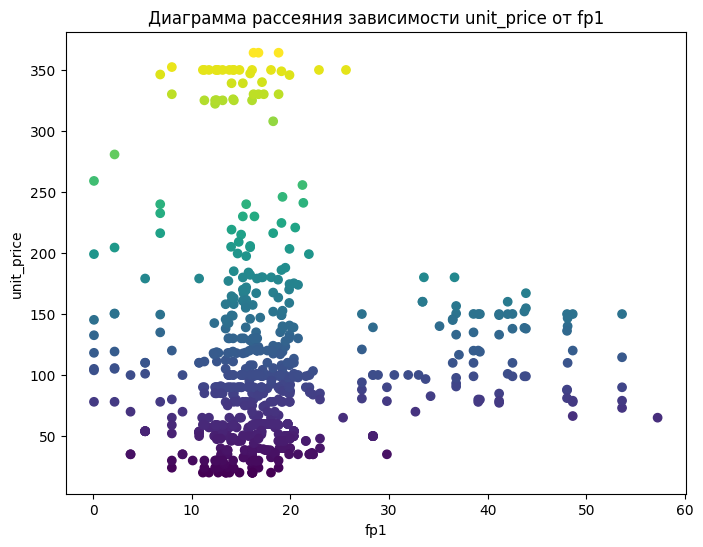

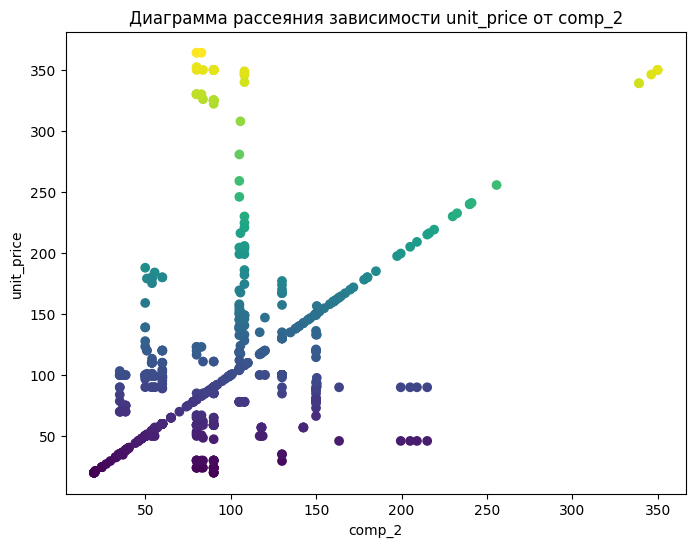

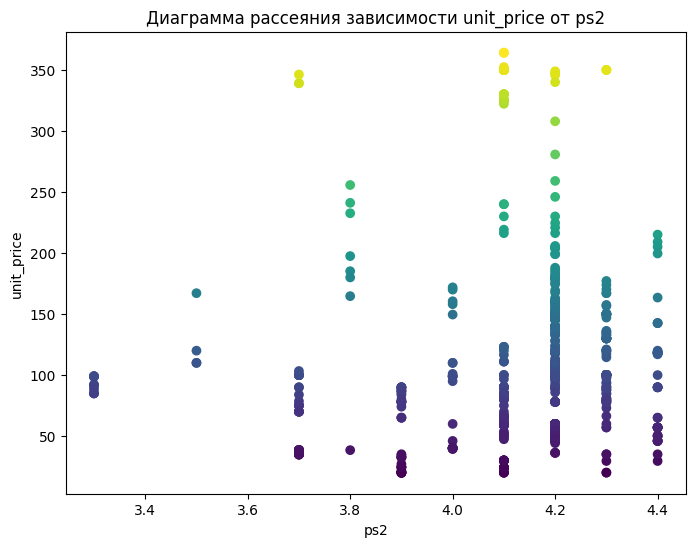

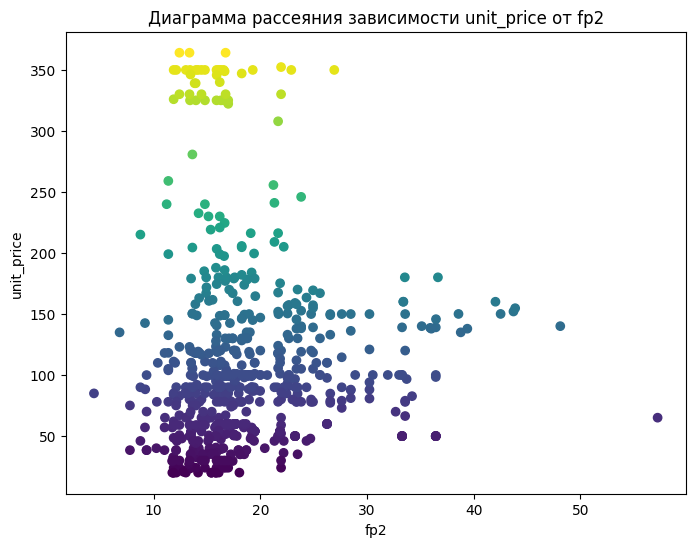

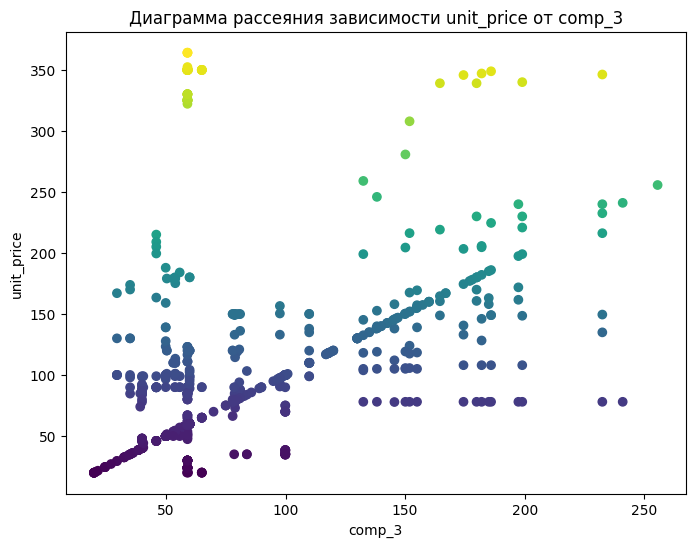

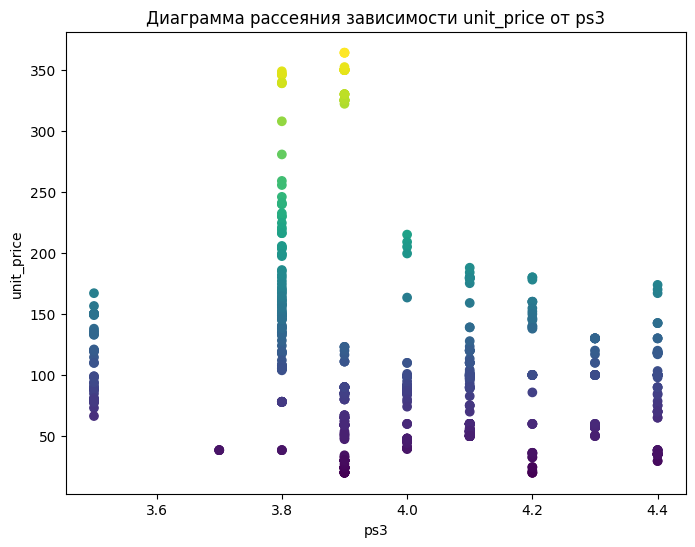

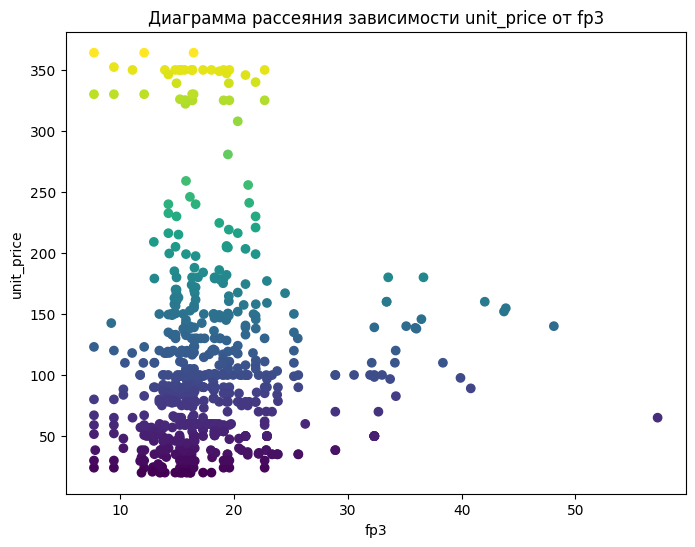

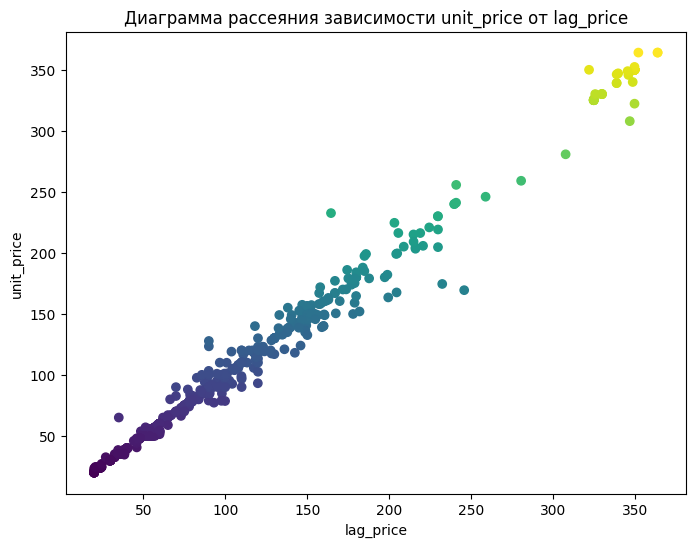

In [10]:
features = [
       'product_id', 'product_category_name', 'qty', 'total_price',
       'freight_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price'
]
target = 'unit_price'


for feature in features:
    plt.figure(figsize=(8, 6))
    plt.scatter(data[feature], data[target], c=data[target])
    plt.title(f'Диаграмма рассеяния зависимости unit_price от {feature}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()

Код функции, которая будет вычислять все нужные метрики

In [11]:
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
    r2 = model.score(X_test, y_test)
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    print(f'RMSE:  {round(RMSE,4)}\n  R2: {round(R2,4)}\n Adjusted R2: {round(adjusted_r2, 4)}\n Cross Validated R2: {round(cv_score.mean(),4)}')
    return R2, adjusted_r2, CV_R2, RMSE

Подготовка датасета к обучению

In [12]:
X = data[features]
y = data['unit_price']
print(f'X shape: {X.shape} | y shape: {y.shape} ')

X shape: (676, 28) | y shape: (676,) 


Train Test разделение (80/20)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

Линейная регрессия

In [14]:
modelLR = LinearRegression()
modelLR.fit(X_train, y_train)
y_pr_LR = modelLR.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelLR, X_train, y_train, X_test, y_test, y_pr_LR)

RMSE:  9.3268
  R2: 0.9864
 Adjusted R2: 0.9828
 Cross Validated R2: 0.9865


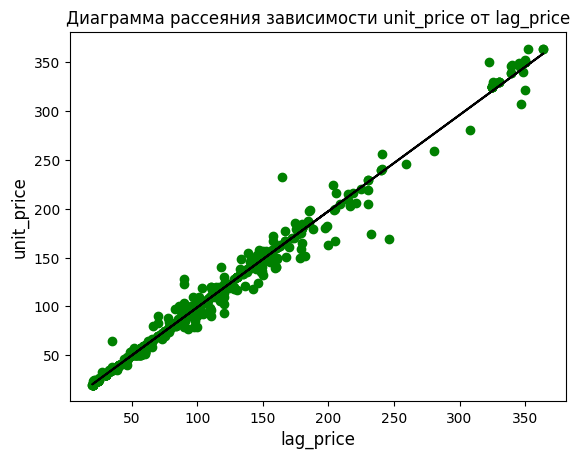

In [15]:
X2 = data['lag_price'].values[:,np.newaxis]
y2 = data['unit_price'].values

model2 = LinearRegression()
model2.fit(X2, y2)

plt.scatter(X2, y2,color='g')
plt.plot(X2, model2.predict(X2),color='k')
plt.ylabel('unit_price', size=12)
plt.xlabel('lag_price', size=12)
plt.title('Диаграмма рассеяния зависимости unit_price от lag_price')
plt.show()

Полиномиальная регрессия

In [16]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(X)
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(poly_features, y, test_size=0.3, random_state=42)

modelPR = LinearRegression()
modelPR.fit(X_p_train, y_p_train)
y_pr_PR = modelPR.predict(X_p_test)

_ = Reg_Models_Evaluation_Metrics(modelPR, X_p_train, y_p_train, X_p_test, y_p_test, y_pr_PR)


RMSE:  97.8006
  R2: -0.5781
 Adjusted R2: 1.0743
 Cross Validated R2: 0.1343


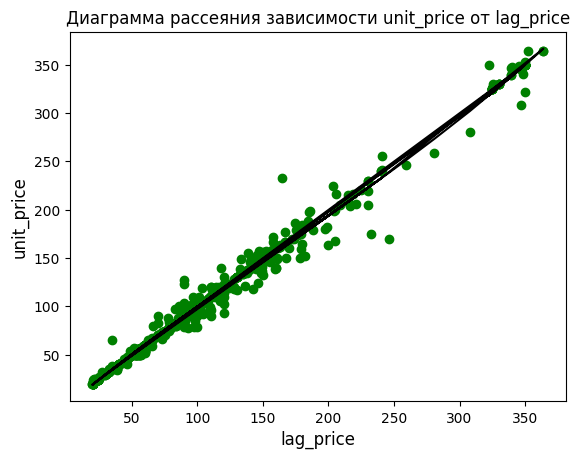

In [17]:
X2 = data['lag_price'].values[:,np.newaxis]
y2 = data['unit_price'].values

poly_features = poly.fit_transform(X2)

model2 = LinearRegression()
model2.fit(poly_features, y2)

plt.scatter(X2, y2,color='g')
plt.plot(X2, model2.predict(poly.fit_transform(X2)),color='k')
plt.ylabel('unit_price', size=12)
plt.xlabel('lag_price', size=12)
plt.title('Диаграмма рассеяния зависимости unit_price от lag_price')
plt.show()

Регрессия дерева принятия решений

In [18]:
modelDT = DecisionTreeRegressor()
modelDT.fit(X_train, y_train)
y_dt_pred = modelDT.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelDT, X_train, y_train, X_test, y_test, y_dt_pred)

RMSE:  9.8691
  R2: 0.9847
 Adjusted R2: 0.9807
 Cross Validated R2: 0.9733


Регрессия случайного леса

In [19]:
modelRF = RandomForestRegressor(n_estimators=100)
modelRF.fit(X_train, y_train)
y_rf_pred = modelRF.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelRF, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  7.6944
  R2: 0.9907
 Adjusted R2: 0.9883
 Cross Validated R2: 0.985


Регрессия опорных векторов (SVR)



In [20]:
modelSVR = SVR(kernel='poly')
modelSVR.fit(X_train, y_train)
y_rf_pred = modelSVR.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelSVR, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  80.0098
  R2: -0.0044
 Adjusted R2: -0.2673
 Cross Validated R2: -0.0015


In [21]:
modelSVR = SVR(kernel='rbf')
modelSVR.fit(X_train, y_train)
y_rf_pred = modelSVR.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelSVR, X_train, y_train, X_test, y_test, y_rf_pred)

RMSE:  78.724
  R2: 0.0276
 Adjusted R2: -0.2269
 Cross Validated R2: 0.0233


Регрессия ElasticNet

In [22]:
modelEN = ElasticNet(alpha=0.1, l1_ratio=0.8)
modelEN.fit(X_train, y_train)
y_en_pred = modelEN.predict(X_test)

_ = Reg_Models_Evaluation_Metrics(modelEN, X_train, y_train, X_test, y_test, y_en_pred)

RMSE:  9.3319
  R2: 0.9863
 Adjusted R2: 0.9828
 Cross Validated R2: 0.9865


Согласно метрикам, науличшими оказалась модели, построенная с помощью регрессии случайного леса, линейной регрессии и регресии ElasticNet

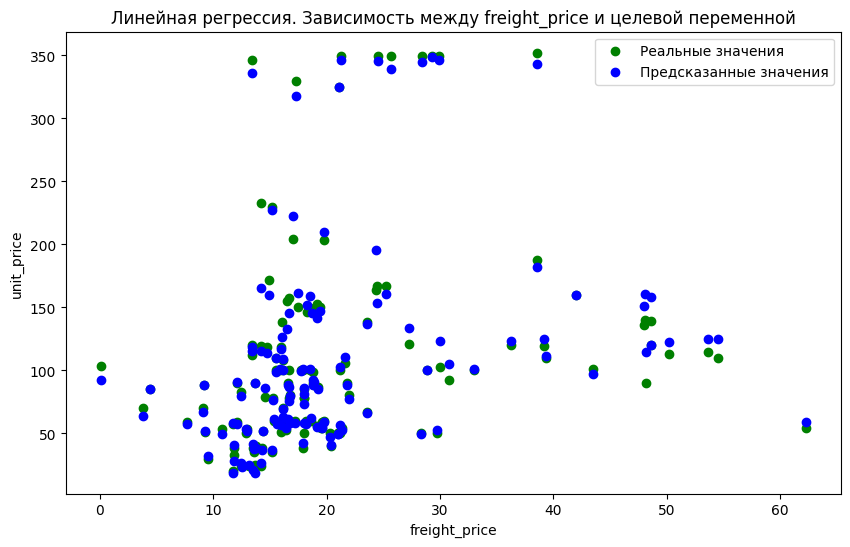

In [49]:
plt.figure(figsize=(10, 6))

plt.scatter(X_test['freight_price'], y_test, color='g', label='Реальные значения')
plt.scatter(X_test['freight_price'], y_pr_LR, color='b', label='Предсказанные значения')
plt.xlabel('freight_price')
plt.ylabel('unit_price')
plt.title('Линейная регрессия. Зависимость между freight_price и целевой переменной')
plt.legend()
plt.show()

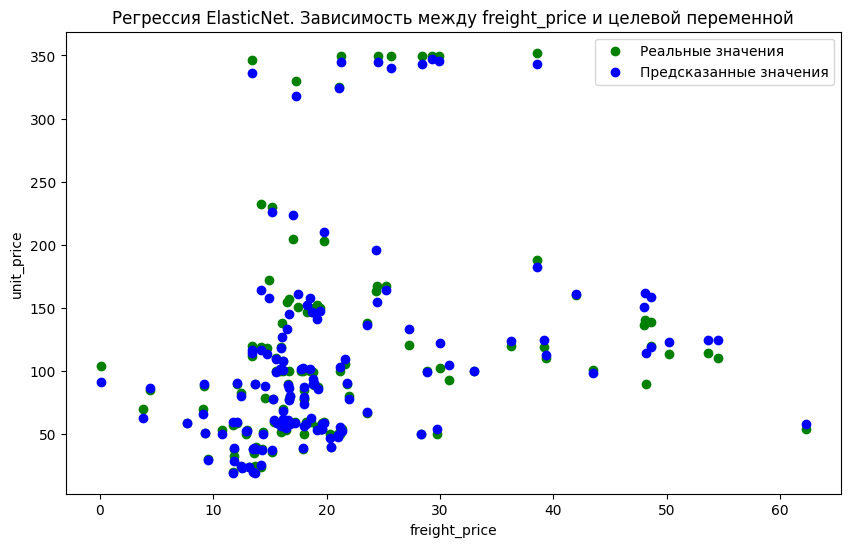

In [50]:
plt.figure(figsize=(10, 6))

plt.scatter(X_test['freight_price'], y_test, color='g', label='Реальные значения')
plt.scatter(X_test['freight_price'], y_en_pred, color='b', label='Предсказанные значения')
plt.xlabel('freight_price')
plt.ylabel('unit_price')
plt.title('Регрессия ElasticNet. Зависимость между freight_price и целевой переменной')
plt.legend()
plt.show()